# Imports

In [107]:
import numpy as np

# import gtda
from gtda.homology import VietorisRipsPersistence
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from gtda.diagrams import BettiCurve, PersistenceLandscape, PairwiseDistance, PersistenceEntropy
from gtda.plotting import plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from pathlib import Path
import plotly.graph_objects as go

import nolds

from statsmodels.tsa.stattools import acf

from scipy.fft import fft, fftfreq

import pandas as pd
import matplotlib.pyplot as plt
import pylab

from pytisean.embedding import false_nearest

import seaborn as sns

import pywt
import matplotlib.gridspec as gridspec

from tqdm import tqdm
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme()


In [108]:
PATH = Path("../data")

`anglez` - As calculated and described by the GGIR package, z-angle is a metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body


`enmo` - As calculated and described by the GGIR package, ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features

In [109]:
# train_series = get_data_from_pq_to_pd(r'/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet', 1)
train_series = pd.read_csv(PATH / 'resampled_dataset.csv')
train_series.head()

,timestamp,anglez,enmo,series_id,step,awake
0,2019-02-08 17:00:00+00:00,-88.683701,0.000000,349c5562ee2c,0,True
1,2019-02-08 17:10:00+00:00,-88.683701,0.000000,349c5562ee2c,120,True
2,2019-02-08 17:20:00+00:00,-81.866323,0.013463,349c5562ee2c,240,True
3,2019-02-08 17:30:00+00:00,-0.461967,0.122138,349c5562ee2c,360,True
4,2019-02-08 17:40:00+00:00,28.880279,0.030445,349c5562ee2c,480,True


In [110]:
train_series["timestamp"] = pd.to_datetime(train_series["timestamp"])

In [111]:
train_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  2736 non-null   datetime64[ns, UTC]
 1   anglez     2736 non-null   float64            
 2   enmo       2736 non-null   float64            
 3   series_id  2736 non-null   object             
 4   step       2736 non-null   int64              
 5   awake      2736 non-null   bool               
dtypes: bool(1), datetime64[ns, UTC](1), float64(2), int64(1), object(1)
memory usage: 109.7+ KB


# TDA

## Временные ряды

In [112]:
anglez_series = train_series["anglez"].to_numpy() # train_series[train_series.series_id == '038441c925bb'].anglez
enmo_series = train_series["enmo"].to_numpy()

In [113]:
fig = go.Figure(data=go.Scatter(y=anglez_series))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Anglez")
fig.show()

fig = go.Figure(data=go.Scatter(y=enmo_series))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="enmo")
fig.show()

### Определение параметров 

#### Определение временной задержки

##### Autocorr function

In [114]:
#plot autocorrelation function
max_delay = 60
acf_y = acf(anglez_series, nlags=max_delay)
fig = go.Figure(data=go.Scatter(y=acf_y))
fig.update_layout(xaxis_title="anglez - Time delay", yaxis_title="Autocorr function")
fig.show()

max_delay = 60
acf_y = acf(enmo_series, nlags=max_delay)
fig = go.Figure(data=go.Scatter(y=acf_y))
fig.update_layout(xaxis_title="enmo - Time delay", yaxis_title="Autocorr function")
fig.show()

##### Wavelet 

In [115]:
def plot_wavelet(data, scales, wavelet, sampling_period):
    cwtmatr, freqs = pywt.cwt(data, scales, wavelet, sampling_period)
    time = train_series["timestamp"]
    cwtmatr = np.abs(cwtmatr[:-1, :-1])

    # fig, axs = plt.subplots(2, 1, figsize=(10, 7))
    pcm = plt.pcolormesh(time, freqs, cwtmatr)
    plt.yscale("log")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Continuous Wavelet Transform (Scaleogram)")
    plt.colorbar(pcm)


['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


/home/vadim/projects/TDA_Uni/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/vadim/projects/TDA_Uni/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



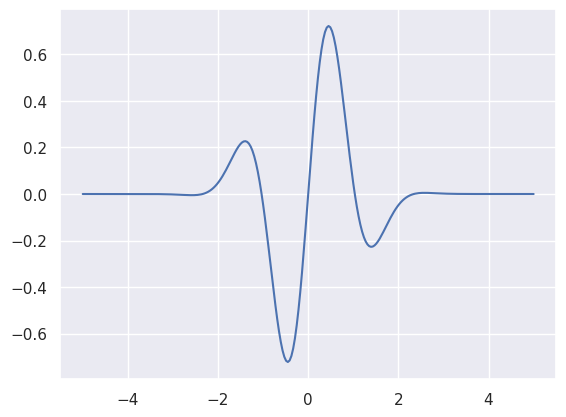

In [116]:
[psi, x] = pywt.ContinuousWavelet("cgau3").wavefun()
print(pywt.wavelist(kind='continuous'))
pylab.plot(x, psi)
pylab.show()


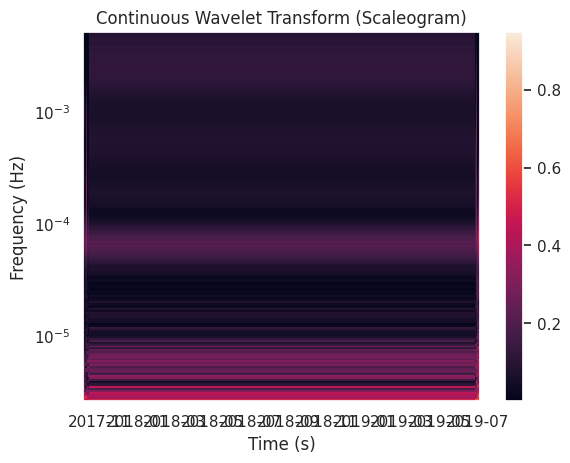

In [117]:
scales = np.geomspace(1, 2048, num=200)
sampling_period  = (train_series["timestamp"][1] - train_series["timestamp"][0]).total_seconds() / (2 * np.pi)
wavelet = "cgau3"
# ['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']
plot_wavelet(data=enmo_series, scales=scales, wavelet=wavelet, sampling_period=sampling_period)

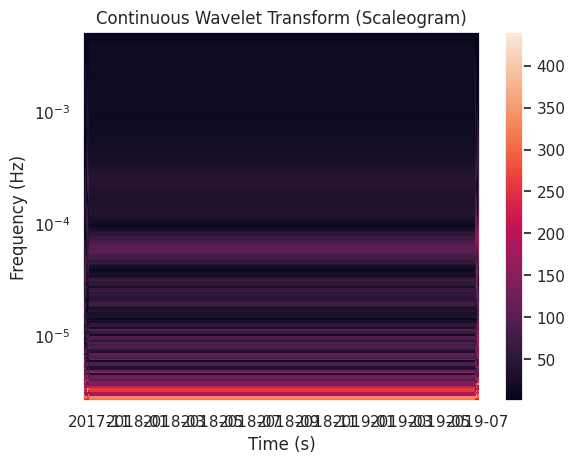

In [118]:
scales = np.geomspace(1, 2048, num=200)
sampling_period  = (train_series["timestamp"][1] - train_series["timestamp"][0]).total_seconds() / (2 * np.pi)
wavelet = "cgau3"
# ['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']
plot_wavelet(data=anglez_series, scales=scales, wavelet=wavelet, sampling_period=sampling_period)

##### Hurst exponent

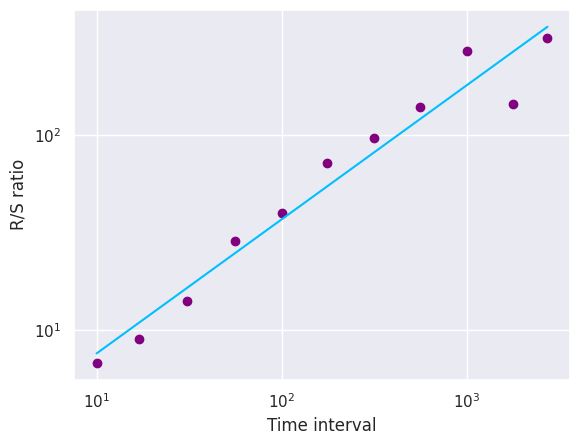

H=0.6849, c=1.5750


In [119]:
from hurst import compute_Hc

# Evaluate Hurst equation
series = anglez_series + abs(anglez_series.min()) + 1e-6
H, c, data = compute_Hc(series, kind='price', )

# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))


#### Размерность вложения

##### Метод корреляционной размерности (Метод Грассберга-Прокаччи)

In [120]:
def get_corr_dims(data, dims: list[int]) -> list[int]:
    corr_dims_list = []
    for embd_dim in tqdm(dims):
        corr_dim = nolds.corr_dim(data, embd_dim)
        corr_dims_list.append(corr_dim)
    return corr_dims_list

100%|██████████| 19/19 [00:12<00:00,  1.54it/s]


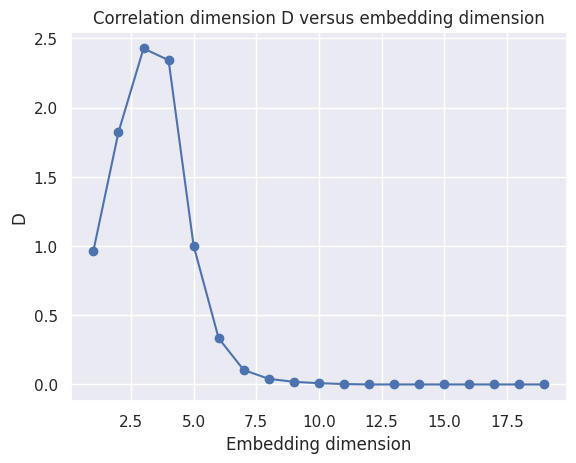

In [121]:
# Calculates the correlation dimension with the Grassberger-Procaccia algorithm
embd_dims_list = list(range(1, 20))
corr_dims = get_corr_dims(anglez_series, embd_dims_list)


plt.plot(embd_dims_list, corr_dims, 'o-')
plt.xlabel("Embedding dimension")
plt.ylabel("D")
plt.title("Correlation dimension D versus embedding dimension")
plt.show()


100%|██████████| 24/24 [00:15<00:00,  1.52it/s]


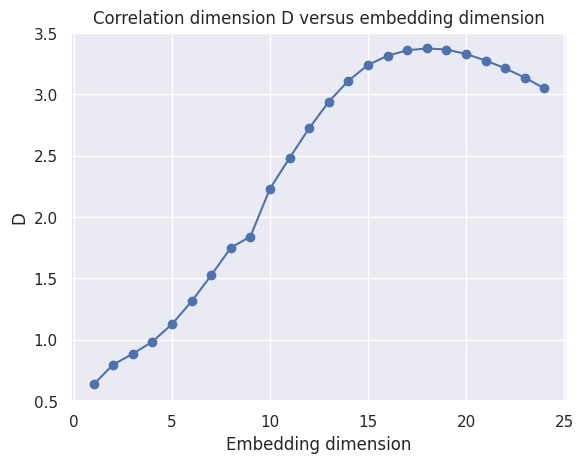

In [122]:
# Calculates the correlation dimension with the Grassberger-Procaccia algorithm
embd_dims_list = list(range(1, 25))
corr_dims = get_corr_dims(enmo_series, embd_dims_list)


plt.plot(embd_dims_list, corr_dims, 'o-')
plt.xlabel("Embedding dimension")
plt.ylabel("D")
plt.title("Correlation dimension D versus embedding dimension")
plt.show()

##### False nearest neighbors

In [129]:
def plot_fft(data, name):
    m = data[:, 0]
    
    fraction_fnn = data[:, 1]
    avg_size_of_neighbors = data[:, 2]
    avg_square_size_of_neighbors = data[:, 3]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(f"{name} | False nearest neighbors (fraction)", fontsize=14)
    
    ax1.plot(m, fraction_fnn, label="the fraction of false nearest neighbors")
    ax2.plot(m, avg_size_of_neighbors, label="the average size of the neighborhood")
    ax2.plot(m, avg_square_size_of_neighbors, label="the average of the squared size of the neighborhood")

    ax1.legend(loc="upper center")
    ax1.set_xlabel("the embedding dimension")
    ax1.set_ylabel("FNN Fraction")

    ax2.legend(loc="upper center")
    ax2.set_ylabel("Size")
    ax2.set_xlabel("the embedding dimension")

    plt.tight_layout()

    plt.show()


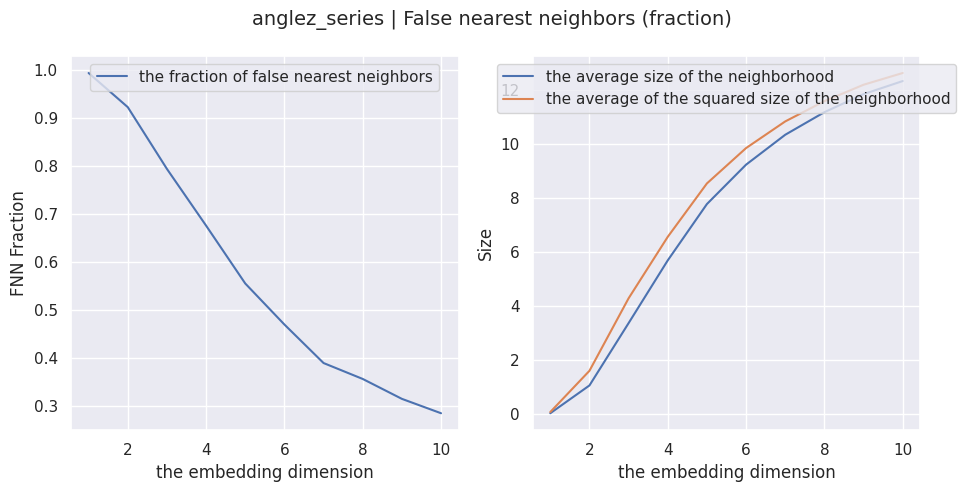

In [130]:
fnn = false_nearest(anglez_series, max_dim=10)
plot_fft(fnn, "anglez_series")

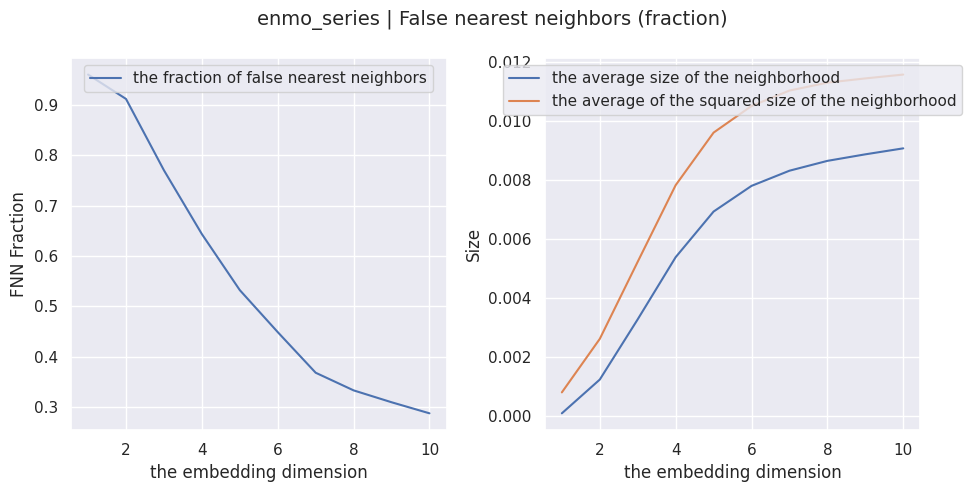

In [131]:
fnn = false_nearest(enmo_series, max_dim=10)
plot_fft(fnn, "enmo_series")

In [127]:
takens_embedding_optimal_parameters(anglez_series, max_time_delay=50, max_dimension=30,  n_jobs=-1)

(46, 9)

In [128]:
takens_embedding_optimal_parameters(enmo_series, max_time_delay=50, max_dimension=30,  n_jobs=-1)

(37, 9)

## Embeddings

In [16]:

embedding_dimension_periodic = 3
embedding_time_delay_periodic = 33

embedder = SingleTakensEmbedding(
    parameters_type="fixed",
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=1 # Иначе слишком много значений, и вычисления не произвести
)
anglez_point_cloud = embedder.fit_transform(anglez_series)
plot_point_cloud(anglez_point_cloud).show()

In [17]:

embedding_dimension_periodic = 17
embedding_time_delay_periodic = 35

embedder = SingleTakensEmbedding(
    parameters_type="fixed",
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=1 # Иначе слишком много значений, и вычисления не произвести
)
enmo_point_cloud = embedder.fit_transform(enmo_series)
plot_point_cloud(enmo_point_cloud).show()

In [21]:
# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=-1
)

In [22]:
diagrams = persistence.fit_transform([anglez_point_cloud, enmo_point_cloud])

In [23]:
VR = VietorisRipsPersistence()
VR.plot(diagrams, sample=0)

In [25]:
VR.plot(diagrams, sample=1)

In [26]:
p_W = 2
PD = PairwiseDistance(metric='wasserstein',
                      metric_params={'p': p_W, 'delta': 0.1},
                      order=None)

PD.fit_transform(diagrams)

array([[[  0.        ,   0.        ,   0.        ],
        [189.05449727,  45.67033296,  10.66067056]],

       [[189.0317042 ,  45.67033296,  10.66067056],
        [  0.        ,   0.        ,   0.        ]]])

In [27]:
PD = PairwiseDistance(metric='bottleneck',
                      metric_params={'delta': 0.1},
                      order=None)

PD.fit_transform(diagrams)

array([[[ 0.        ,  0.        ,  0.        ],
        [15.02049065,  7.99650898,  2.54906563]],

       [[15.94411527,  7.9996409 ,  2.55601823],
        [ 0.        ,  0.        ,  0.        ]]])

In [28]:
BC = BettiCurve()
betti_curves = BC.fit_transform(diagrams)

In [29]:
BC.plot(betti_curves, sample=0)

In [31]:
BC.plot(betti_curves, sample=1)

In [32]:
PD = PairwiseDistance(metric='betti',
                      metric_params={'p': 1},
                      order=None)

PD.fit_transform(diagrams)

array([[[    0.        ,     0.        ,     0.        ],
        [16299.50818322,  2392.2918235 ,   299.46171526]],

       [[16299.50818322,  2392.2918235 ,   299.46171526],
        [    0.        ,     0.        ,     0.        ]]])

In [33]:
PL = PersistenceLandscape()
persistence_landscapes = PL.fit_transform(diagrams)

In [34]:
PL.plot(persistence_landscapes, sample=0)

In [35]:
PL.plot(persistence_landscapes, sample=1)

In [36]:
PD = PairwiseDistance(metric='landscape',
                      metric_params={'p': 1},
                      order=None)

PD.fit_transform(diagrams)

array([[[  0.        ,   0.        ,   0.        ],
        [225.59211965, 160.02969527,  28.890392  ]],

       [[225.59211965, 160.02969527,  28.890392  ],
        [  0.        ,   0.        ,   0.        ]]])

# Машинное обучение

In [ ]:
# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    collapse_edges=True,
)

diagrams_basic = persistence.fit_transform(point_clouds_basic)

In [ ]:
# Circle
plot_diagram(diagrams_basic[0])

In [ ]:
#spheres
plot_diagram(diagrams_basic[10])

In [ ]:
#tori
plot_diagram(diagrams_basic[-1])

In [ ]:
persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_basic = persistence_entropy.fit_transform(diagrams_basic)

In [ ]:
plot_point_cloud(X_basic)

In [ ]:
rf = RandomForestClassifier(oob_score=True)
rf.fit(X_basic, labels_basic)

print(f"OOB score: {rf.oob_score_:.3f}")

In [ ]:
steps = [
    ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)),
    ("entropy", PersistenceEntropy()),
    ("model", RandomForestClassifier(oob_score=True)),
]

pipeline = Pipeline(steps)

pipeline.fit(point_clouds_basic, labels_basic)

Pipeline(steps=[('persistence',
                 VietorisRipsPersistence(homology_dimensions=[0, 1, 2])),
                ('entropy', PersistenceEntropy()),
                ('model', RandomForestClassifier(oob_score=True))])

pipeline["model"].oob_score_

Julia + Eirene

In [ ]:
x = Main.rand(3,50)
plot_point_cloud(x.T)

In [ ]:
C = Main.eirene(x, model = "pc")

In [ ]:
A0 = Main.barcode(C, dim=0)
A0 = np.append(np.array(A0), np.zeros((len(A0), 1)), axis= 1 )
A0 = np.delete(A0, -1, 0)

In [ ]:
A1 = Main.barcode(C, dim=1)
A1 = np.append(np.array(A1), np.ones((len(A1), 1)), axis= 1 )

In [ ]:
A = np.concatenate((A0, A1), axis=0)
plot_diagram(A)

In [ ]:
Main.wasserstein_distance(dgm1, dgm2, q=q, p=p)

In [ ]:
Main.betticurve(C, dim=0)

In [ ]:
Main.betticurve(C, dim=1)

In [ ]:
BC = BettiCurve()
betti_curves = BC.fit_transform([A])
BC.plot(betti_curves, sample=0)

In [ ]:
Main.classrep(C, dim=1)

In [ ]:
Main.classrep(C, dim=0)

In [ ]:
Main.classrep(C, dim=0, class=1)